In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import obnb
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from obnb.dataset import OpenBiomedNetBench
from tqdm import tqdm

sns.set()
BARFMT = "{l_bar}{bar:40}{r_bar}{bar:-40b}"
VERSION = obnb.__data_version__

/mnt/home/liurenmi/software/anaconda3/envs/obnb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load selected results
selected_models = {
    "GCN",
    "GAT",
    "GIN",
    "SAGE",
    "GatedGCN",
    "GCN+CS",
    "GAT+CS",
    "GIN+CS",
    "SAGE+CS",
    "GatedGCN+CS",
    "GCN+Node2vec",
    "GAT+Node2vec",
    "GIN+Node2vec",
    "SAGE+Node2vec",
    "GatedGCN+Node2vec",
    "GCN+BoT",
    "GAT+BoT",
    "GIN+BoT",
    "SAGE+BoT",
    "GatedGC+BoTN",
    "LogReg+Adj",
    "LogReg+Node2vec",
    "LogReg+LapEigMap",
    "LabelProp",
}

score_df = (
    pd.read_csv("../results/main.csv.gz")
    .query("split == 'test' & score_type == 'APOP'")
    .groupby(["name", "task_id"], as_index=False)
    .mean(numeric_only=True)
)

score_df = score_df.loc[~score_df["name"].str.contains("-BoT")]
score_df[["network", "label", "model"]] = score_df["name"].str.split("-", expand=True)
score_df = score_df.loc[score_df["model"].isin(selected_models)]
score_df = score_df.drop(columns="name")
score_df

,task_id,score_value,network,label,model
0,MONDO:0000066,3.720390,BioGRID,DISEASES,GAT
1,MONDO:0000226,0.832281,BioGRID,DISEASES,GAT
2,MONDO:0000425,0.080663,BioGRID,DISEASES,GAT
3,MONDO:0000426,0.195115,BioGRID,DISEASES,GAT
4,MONDO:0000462,0.246171,BioGRID,DISEASES,GAT
...,...,...,...,...,...
258566,GO:0072659,1.194745,STRING,GOBP,SAGE
258567,GO:0090090,2.358861,STRING,GOBP,SAGE
258568,GO:0090263,1.592249,STRING,GOBP,SAGE
258569,GO:0098609,2.771737,STRING,GOBP,SAGE


In [3]:
# Compute homophily measures
# ----------------------
networks = ["BioGRID", "HumanNet"]
labels = ["DisGeNET", "GOBP"]
metric = "APOP"

eval_on_test_only = False
# ----------------------

stats_dict = {}
for network, label in tqdm(
    itertools.product(networks, labels),
    total=len(networks) * len(labels),
    bar_format=BARFMT,
):
    dataset = OpenBiomedNetBench(
        "../datasets",
        version=VERSION,
        graph_name=network,
        label_name=label,
        log_level="ERROR",
    )
    
    adj = dataset.graph.to_dense_graph().mat
    y = dataset.label.get_y(dataset.graph.node_ids)
    
    # Propagation matrix
    P = adj / adj.sum(1, keepdims=True)
    
    if eval_on_test_only:  # if set to True, might need to use log1p instead
        mask = dataset.masks["test"].ravel()
        y_masked = y.copy()
        y_masked[mask] = 0
        z = P @ y 
    else:
        mask = y.any(1)
        z = P @ y

    h_pos = (z[mask] * y[mask]).sum(0) / y[mask].sum(0)
    h_neg = (z[mask] * (1 - y[mask])).sum(0) / (1 - y[mask]).sum(0)
    h = np.log2(h_pos / h_neg)  # corrected homophily ratio
    
    # Register results
    stats_dict[(network, label)] = {}
    stats_dict[(network, label)]["task_ids"] = dataset.label.label_ids
    stats_dict[(network, label)]["h_pos"] = h_pos
    stats_dict[(network, label)]["h_neg"] = h_neg
    stats_dict[(network, label)]["h"] = h

    # Prepare more gene set properties
    train_mask = dataset.masks["train"].ravel()
    test_mask = dataset.masks["test"].ravel()

    # Size
    stats_dict[(network, label)]["size"] = y.sum(0).tolist()

    # Average degrees
    stats_dict[(network, label)]["avg_deg"] = []
    deg = adj.sum(0)
    for j in y.T:
        stats_dict[(network, label)]["avg_deg"].append(deg[j].mean())

    # Density
    stats_dict[(network, label)]["density"] = []
    for j in y.T:
        density = adj[np.ix_(j, j)].sum() / (j.sum() * (j.sum() - 1))
        stats_dict[(network, label)]["density"].append(density)

    # Bipartite density (how well testing nodes are connected to training nodes)
    stats_dict[(network, label)]["bipartite_density"] = []
    for j in y.T:
        j_train, j_test = j & train_mask, j & test_mask
        bipartite_density = adj[np.ix_(j_train, j_test)].sum() / (j_train.sum() * j_test.sum())
        stats_dict[(network, label)]["bipartite_density"].append(bipartite_density)

    # Segregation (how isolated the gene set is from the rest of the graph)
    stats_dict[(network, label)]["segregation"] = []
    for j in y.T:
        segregation = adj[np.ix_(j, j)].sum() / (adj[j].sum() + adj[:, j].sum() - adj[np.ix_(j, j)].sum())
        stats_dict[(network, label)]["segregation"].append(segregation)

    
    # Release memory
    del dataset, adj,y, P, z, mask, h_pos, h_neg, h

  0%|                                        | 0/4 [00:00<?, ?it/s]                                                                                                                                                                                                                   /mnt/home/liurenmi/software/anaconda3/envs/obnb/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
 25%|██████████                              | 1/4 [00:54<02:44, 54.98s/it]                                                                                                                                                                                                           /mnt/home/liurenmi/software/anaconda3/envs/obnb/lib/python3.8/site-packages/sklearn/preprocessing/_dis

In [4]:
# Combine scores and stats into a dataframe
stats_dfs = []
for (network, label), stats in stats_dict.items():
    stats_dfs.append(pd.DataFrame(stats))
    stats_dfs[-1] = stats_dfs[-1].rename(columns={"task_ids": "task_id"})
    stats_dfs[-1]["network"] = network
    stats_dfs[-1]["label"] = label
stats_df = pd.concat(stats_dfs).set_index(["network", "label", "task_id"])

result_df = stats_df.join(
    score_df.pivot_table("score_value", ["network", "label", "task_id"], "model"),
    how="inner",
)
result_df["dataset"] = (
    result_df.index.get_level_values("network")
    + "-"
    + result_df.index.get_level_values("label")
)
result_df

h_pos     h_neg         h  size  \
network  label    task_id                                             
BioGRID  DisGeNET MONDO:0021034  0.023290  0.011456  1.023601    68   
                  MONDO:0002243  0.046583  0.017009  1.453484   134   
                  MONDO:0002245  0.056289  0.034700  0.697924   326   
                  MONDO:0001703  0.024611  0.008595  1.517724    86   
                  MONDO:0013099  0.016182  0.003353  2.270671    57   
...                                   ...       ...       ...   ...   
HumanNet GOBP     GO:0001227     0.059399  0.009350  2.667402   148   
                  GO:0003714     0.045760  0.008765  2.384232   117   
                  GO:0007601     0.077608  0.005054  3.940833    73   
                  GO:0045727     0.042865  0.004212  3.347065    50   
                  GO:0030512     0.088281  0.004315  4.354525    60   

                                    avg_deg   density  bipartite_density  \
network  label    task_id                                                  
BioGRID  DisGeNET MONDO:0021034  208.867647  0.036874           0.002174   
                  MONDO:0002243  140.268657  0.021210           0.004202   
                  MONDO:0002245  137.742331  0.016933           0.002527   
                  MONDO:0001703  117.523256  0.015048           0.001887   
                  MONDO:0013099   76.684211  0.014411           0.003175   
...                                     ...       ...                ...   
HumanNet GOBP     GO:0001227     326.227924  0.131722           0.063905   
                  GO:0003714     307.614895  0.119960           0.037334   
                  GO:0007601     413.997218  0.411115           0.314431   
                  GO:0045727     390.453945  0.259036           0.128188   
                  GO:0030512     304.536164  0.303151           0.035184   

                                 segregation       GAT   GAT+BoT  ...  \
network  label    task_id                                         ...   
BioGRID  DisGeNET MONDO:0021034     0.005949  0.135022 -0.023989  ...   
                  MONDO:0002243     0.010157  0.115286  1.872180  ...   
                  MONDO:0002245     0.020383  0.494432  0.743595  ...   
                  MONDO:0001703     0.005472  2.176753  4.171776  ...   
                  MONDO:0013099     0.005290  0.479412  1.375368  ...   
...                                      ...       ...       ...  ...   
HumanNet GOBP     GO:0001227        0.030585  2.848708  3.275196  ...   
                  GO:0003714        0.023142  2.635634  4.090679  ...   
                  GO:0007601        0.037075  4.531826  5.068935  ...   
                  GO:0045727        0.016522  4.893294  6.634820  ...   
                  GO:0030512        0.030254  1.505656  2.403619  ...   

                                 GatedGCN  GatedGCN+CS  LabelProp  LogReg+Adj  \
network  label    task_id                                                       
BioGRID  DisGeNET MONDO:0021034  1.028802    -0.184103  -0.000300    1.528159   
                  MONDO:0002243 -0.003772     1.052125   0.997710    0.128745   
                  MONDO:0002245  0.553811     0.407167   0.343551    1.097792   
                  MONDO:0001703  1.148535     4.150836   4.173243    0.230342   
                  MONDO:0013099  0.075733     1.296320   1.482645    0.052759   
...                                   ...          ...        ...         ...   
HumanNet GOBP     GO:0001227     2.868159     3.228017   2.743416    3.635402   
                  GO:0003714     3.240192     3.726021   3.352771    4.272436   
                  GO:0007601     4.551790     4.982037   4.561408    4.996646   
                  GO:0045727     6.217250     6.586080   5.663111    6.641130   
                  GO:0030512     2.820966     2.843184   2.383697    2.222392   

                                 LogReg+LapEigMap  LogReg+Node2vec      SAGE  \
network  label    task_id              

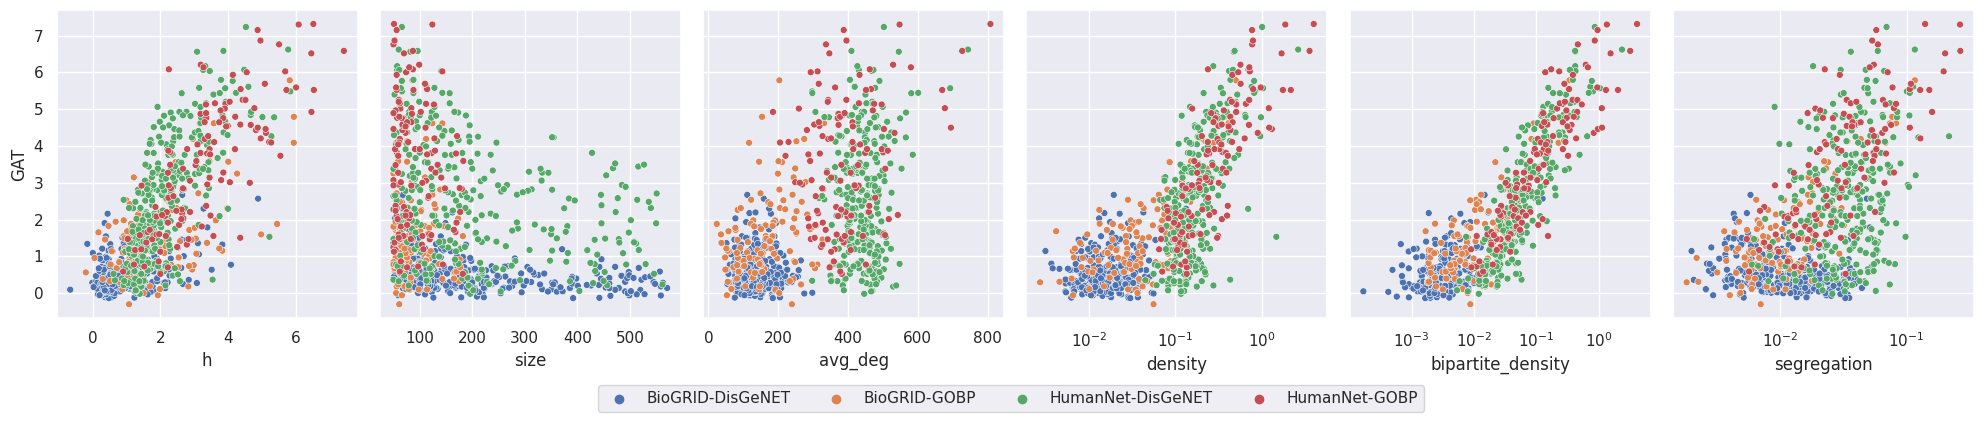

In [5]:
# ----------------
model = "GAT"
# ----------------

fig, axes = plt.subplots(1, 6, figsize=(20, 4), sharey=True)
for i, (ax, stat_type) in enumerate(zip(axes, ["h", "size", "avg_deg", "density", "bipartite_density", "segregation"])):
    sns.scatterplot(
        data=result_df,
        x=stat_type,
        y=model,
        hue="dataset",
        ax=ax,
        s=25,
    )
    ax.get_legend().remove()

    if stat_type in ("density", "bipartite_density", "segregation"):
        ax.set_xscale("log")

plt.tight_layout()
plt.legend(loc="center", bbox_to_anchor=(-2.2, -0.26), ncols=4)
plt.show()

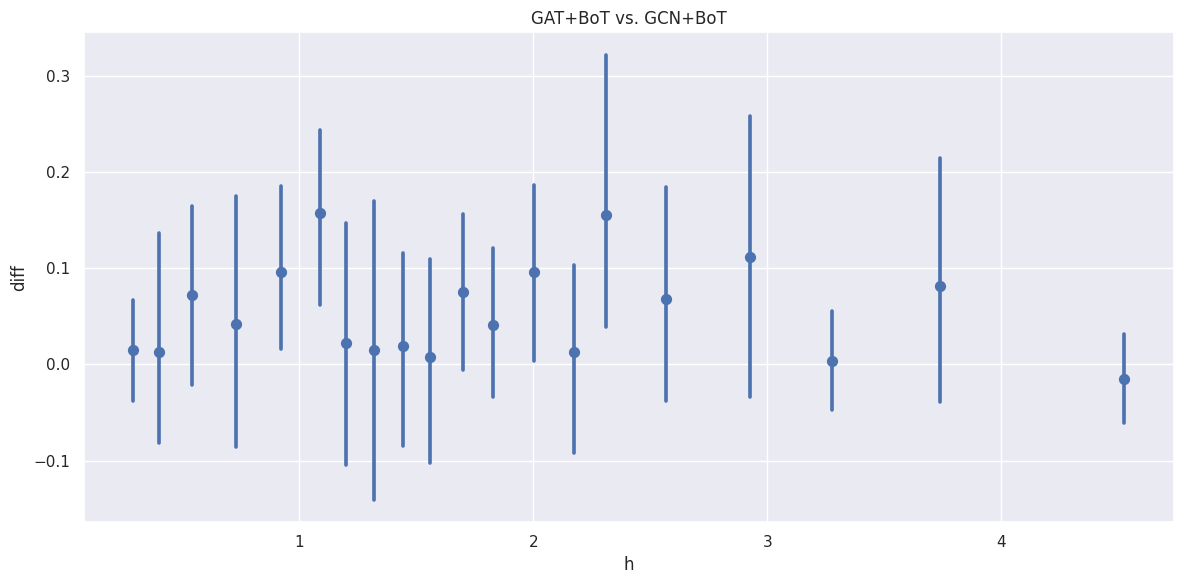

In [6]:
# Performance difference between two models as a function of homohpily
# ------------------------
model1 = "GAT+BoT"
model2 = "GCN+BoT"
stat_type = "h"

plot_scatter = False
# -----------------

datasets = list(itertools.product(networks, labels))

plt.figure(figsize=(12, 6))
# diff_df = result_df.query("model == @model1 | model == @model2").loc[:, ["dataset", stat_type, model1, model2]]
diff_df = result_df.loc[:, ["dataset", stat_type, model1, model2]]
diff_df["diff"] = diff_df[model1] - diff_df[model2]

if plot_scatter:
    sns.scatterplot(
        data=diff_df,
        x=stat_type,
        y="diff",
        hue="dataset",
        s=20,
    )
    plt.legend(loc="right", bbox_to_anchor=(1.4, 0.5))
else:
    sns.regplot(
        data=diff_df,
        x=stat_type,
        y="diff",
        x_bins=20,
        fit_reg=False,
    )

plt.title(f"{model1} vs. {model2}")
plt.tight_layout()
plt.show()

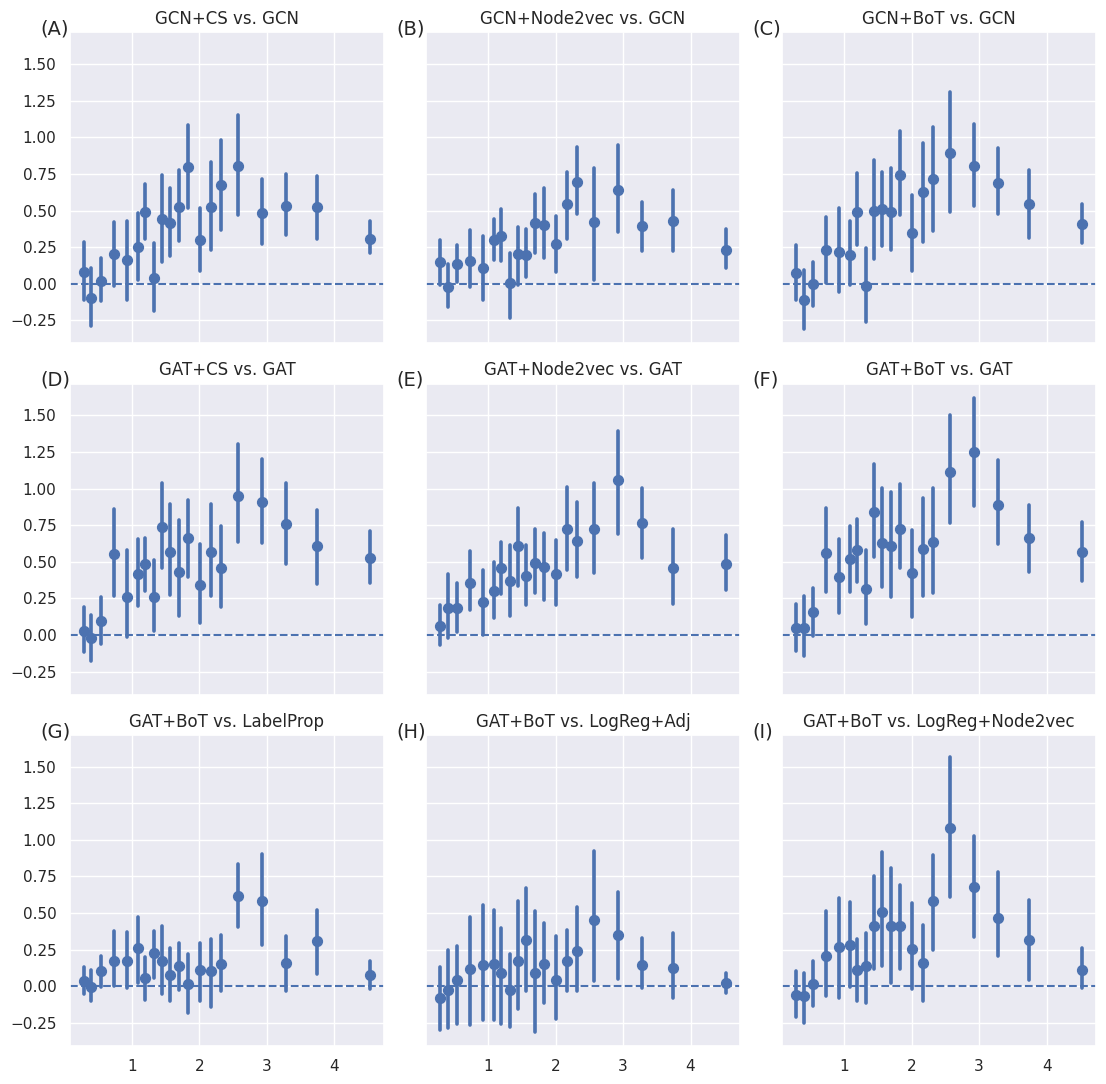

In [7]:
# Performance difference between two models as a function of homohpily
# ------------------------
model1_list = [
    "GCN+CS",
    "GCN+Node2vec",
    "GCN+BoT",
    "GAT+CS",
    "GAT+Node2vec",
    "GAT+BoT",
    "GAT+BoT",
    "GAT+BoT",
    "GAT+BoT",
]
model2_list = [
    "GCN",
    "GCN",
    "GCN",
    "GAT",
    "GAT",
    "GAT",
    "LabelProp",
    "LogReg+Adj",
    "LogReg+Node2vec",
]
annot_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
stat_type = "h"
# -----------------

datasets = list(itertools.product(networks, labels))

fig, axes = plt.subplots(3, 3, figsize=(11, 11), sharex=True, sharey=True)
for ax, model1, model2, annot in zip(axes.ravel(), model1_list, model2_list, annot_list):
    diff_df = result_df.loc[:, ["dataset", stat_type, model1, model2]]
    diff_df["diff"] = diff_df[model1] - diff_df[model2]
    
    sns.regplot(data=diff_df, x=stat_type, y="diff", x_bins=20, fit_reg=False, ax=ax)
    
    ax.set_title(f"{model1} vs. {model2}", fontsize=12)
    # ax.set_ylabel("Test APOP difference")
    # ax.set_xlabel("Corrected homophily ratio")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.text(-0.36, 1.7, f"({annot})", size=14)
    ax.axhline(0, linestyle="--")

plt.tight_layout()
# plt.savefig("perf_diff_vs_h.pdf", bbox_inches="tight")  # uncomment to save
plt.show()

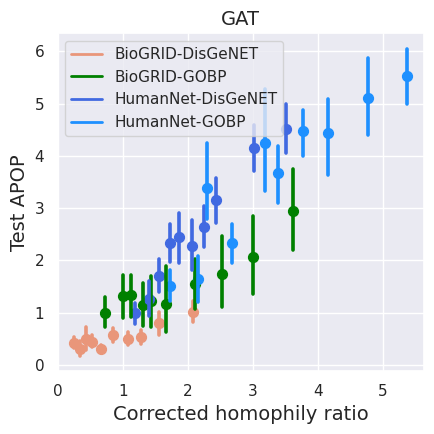

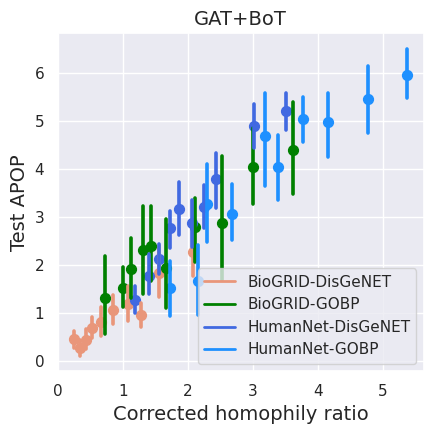

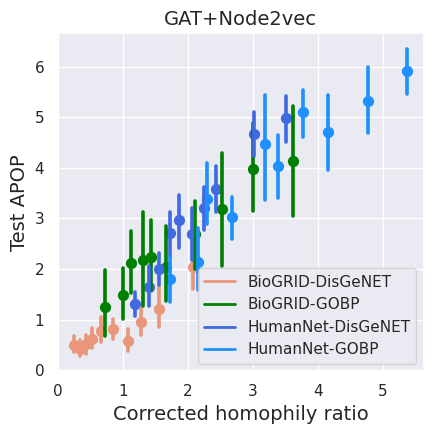

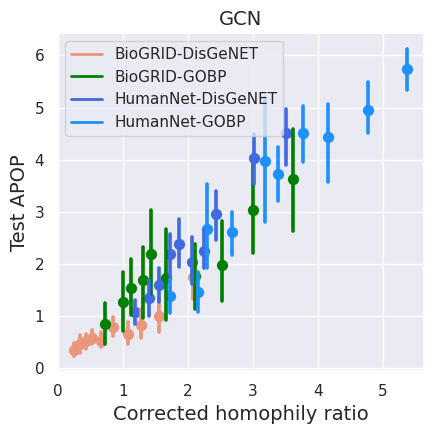

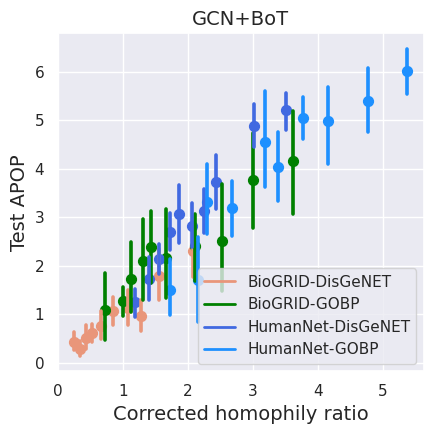

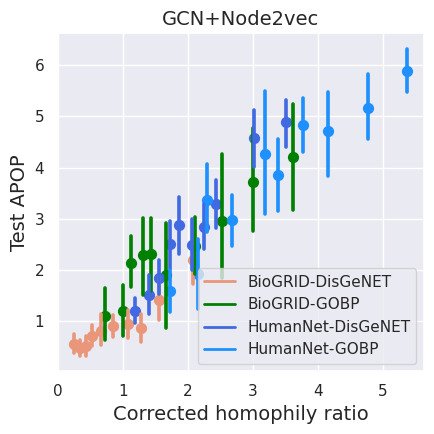

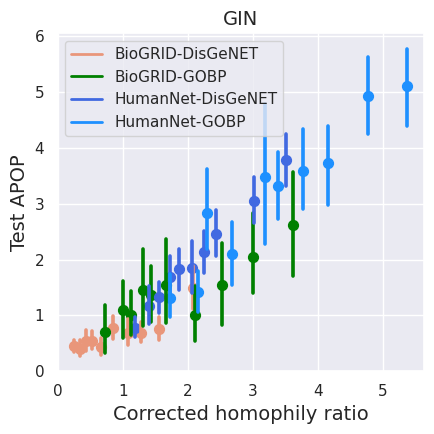

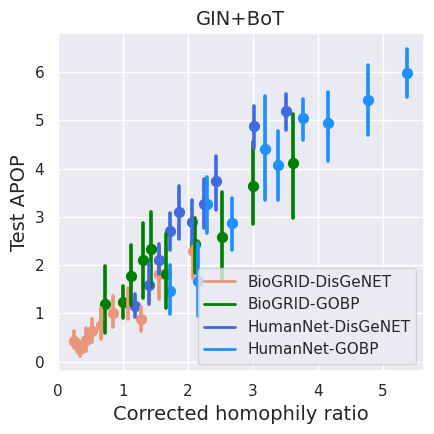

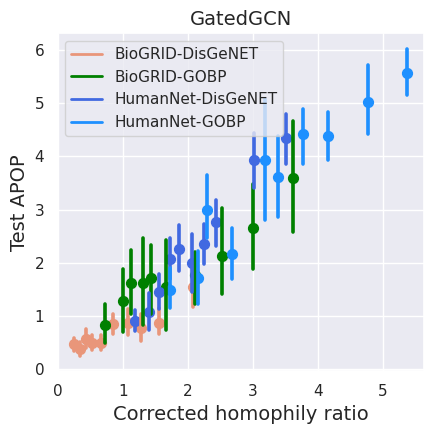

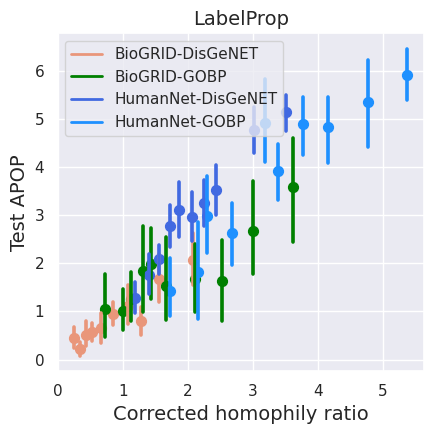

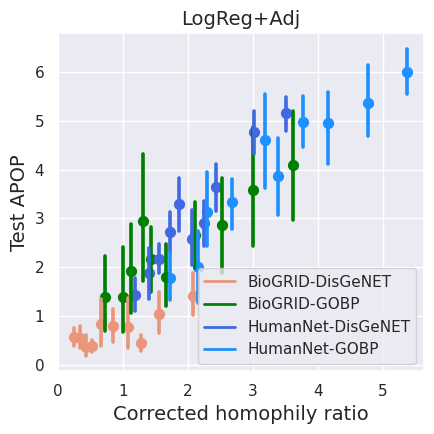

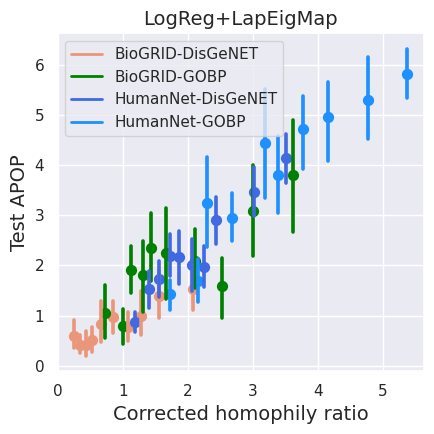

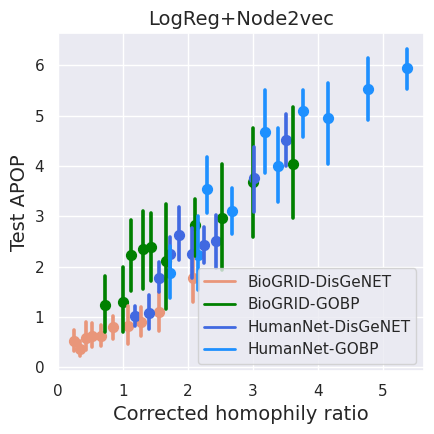

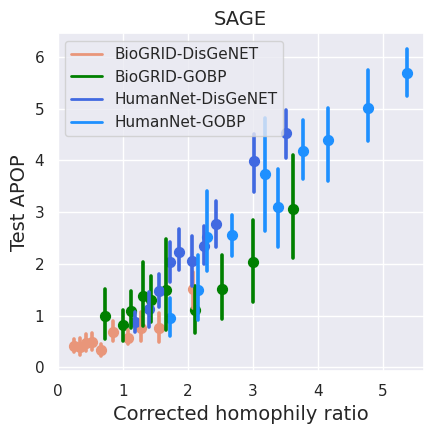

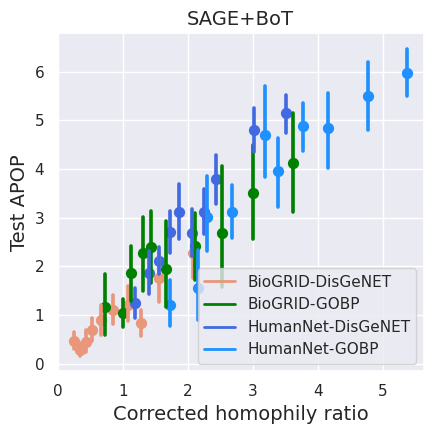

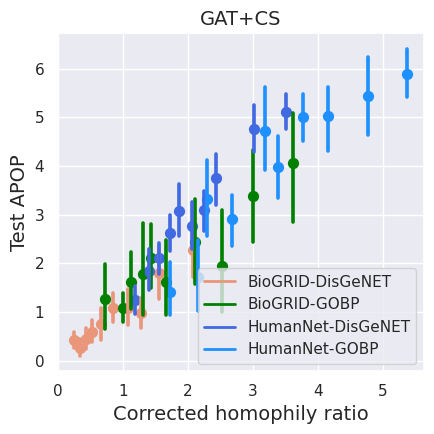

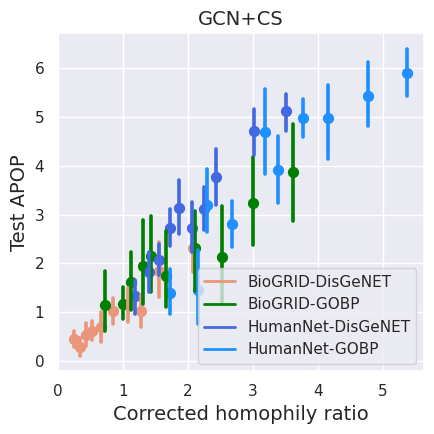

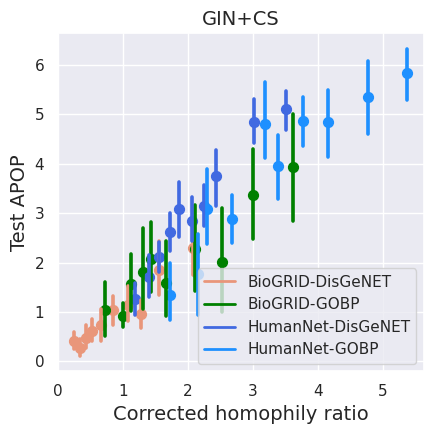

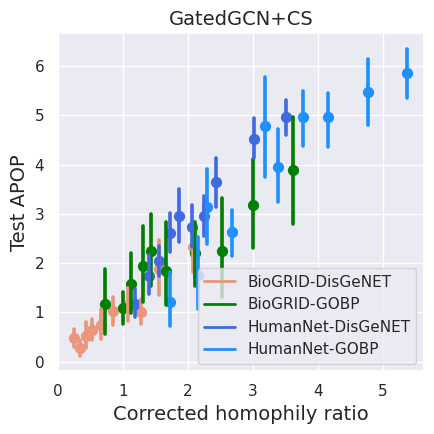

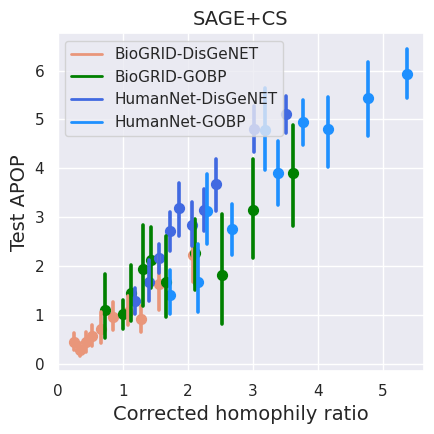

In [8]:
# -----------------
stat_type = "h"  # ["h", "h_pos", "h_neg"]
stat_type_name_dict = {
    "h": "Corrected homophily ratio",
    "h_pos": "Homophily ratio",
    "h_neg": "Negative homophily ratio",
}

color_dict = {
    ("BioGRID", "DisGeNET"): "darksalmon",
    ("BioGRID", "GOBP"): "green",
    ("HumanNet", "DisGeNET"): "royalblue",
    ("HumanNet", "GOBP"): "dodgerblue",
}

plot_scatter = False
# -----------------

# Make shared legends
legend_lines, legend_names = [], []
for (network, label), color in color_dict.items():
    legend_names.append(f"{network}-{label}")
    legend_lines.append(Line2D([0], [0], color=color, lw=2))

# Generate plots
for model in score_df["model"].unique():
    plt.figure(figsize=(4.5, 4.5))
    for (network, label), color in color_dict.items():
        if plot_scatter:
            sns.scatterplot(
                data=result_df.query("network == @network & label == @label"),
                x=stat_type,
                y=model,
                color=color,
            )
        else:
            sns.regplot(
                data=result_df.query("network == @network & label == @label"),
                x=stat_type,
                y=model,
                x_bins=10,
                fit_reg=False,
                color=color,
            )

    plt.title(model, fontsize=14)
    plt.legend(legend_lines, legend_names)
    plt.xlabel(stat_type_name_dict[stat_type], fontsize=14)
    plt.ylabel(f"Test {metric}", fontsize=14)
    plt.tight_layout()
    # plt.savefig(f"perf_analysis_{model}_{stat_type}.pdf", bbox_inches="tight")  # uncomment to save
    plt.show()